## MIRACA Road Flow Model
In this example, we developed a process-based network flow model to simulate passenger car flows across the EU road network. For demonstration purposes and to minimise computational requirements, we randomly sampled 1,000 travel records from ETIS2010, using NUTS-3 regions to represent the origins and destinations of local trips. To simplify the road network, only motorways were included.  

The model employs an iterative method to simulate the congested equilibrium flow assignment process, accounting for road capacities. A speed-flow relationship is embedded to predict variations in traffic speeds as vehicle volumes increase, incorporating maximum and minimum speed limits.  

The model outputs flow patterns and associated travel costs, including tolls, vehicle operational costs, and time-equivalent costs. It also identifies trip isolations caused by network disconnectivity. While the observed disconnectivity in this demonstration results from the limited inclusion of motorways, the model can be adapted to assess disruptions caused by extreme hazards. This extension could support the analysis of network damage and connectivity loss due to climate-induced disruptions.  

In [2]:
from pathlib import Path
import pandas as pd
import geopandas as gpd 
import sys
sys.path.append(str(Path.cwd().parent))
import src.roads as func
import json
import warnings
from collections import defaultdict
import matplotlib.pyplot as plt
from itertools import islice

warnings.simplefilter("ignore")
base_path = Path.cwd() / "inputs"
outpath = Path.cwd() / "outputs"

### Read model parameters

In [3]:
with open(base_path / "flow_breakpoint_dict.json", "r") as f: # breakpoint of flow speed
    flow_breakpoint_dict = json.load(f)
with open(base_path / "flow_cap_dict.json", "r") as f: # edge capacity
    flow_capacity_dict = json.load(f)
with open(base_path / "free_flow_speed_dict.json", "r") as f: # free-flow speed
    free_flow_speed_dict = json.load(f)
with open(base_path /  "min_speed_cap.json", "r") as f: # minimum speed limit
    min_speed_dict = json.load(f)
with open(base_path / "urban_speed_cap.json", "r") as f: # urban speed limit
    urban_speed_dict = json.load(f)

### Read network components (motorways only)

In [4]:
road_node_file = gpd.read_parquet(base_path / "etisplus_road_nodes.pq")
road_link_file = gpd.read_parquet(base_path / "etisplus_road_links.pq")

In [5]:
# add/initialise key columns
# road nodes
road_node_file["id"] = road_node_file["Network_Node_ID"].astype(str)
road_node_file["nd_id"] = road_node_file["Network_Node_ID"].astype(str)
# road links
road_link_file["id"] = road_link_file["Network_Edge_ID"].astype(str)
road_link_file["e_id"] = road_link_file["Network_Edge_ID"].astype(str)
road_link_file["from_id"] = road_link_file["Network_Node_A_ID"].astype(str)
road_link_file["to_id"] = road_link_file["Network_Node_B_ID"].astype(str)
road_link_file["road_classification"] = "Motorway" 
road_link_file["form_of_way"] = "Dual Carriageway"
road_link_file["urban"] = 0 # suburban roads
road_link_file["average_toll_cost"] = 0 # ignore tolls

In [6]:
road_link_file.shape

(18449, 16)

In [7]:
road_link_file.dtypes

Network_Edge_ID                int64
Manually_Added                 int64
Distance                     float64
Network_Node_A_ID              int64
Network_Node_B_ID              int64
Traffic_flow_trucks_2019       int64
Traffic_flow_trucks_2030       int64
geometry                    geometry
id                            object
e_id                          object
from_id                       object
to_id                         object
road_classification           object
form_of_way                   object
urban                          int64
average_toll_cost              int64
dtype: object

In [8]:
road_link_file = road_link_file.drop_duplicates(subset = "e_id") # drop duplicates

In [9]:
road_link_file.reset_index(drop = True, inplace= True)
road_link_file.shape

(18446, 16)

### Read od file (1000 samples from ETIS2010 dataset)


In [10]:
car = pd.read_csv(base_path / "sample_p_transport_car.csv") # ETIS2010 passenger travels by roads

In [11]:
car.shape

(1000, 6)

In [12]:
car.head()

,ID,ORIGINZONE_3_ID,DEST_ZONE_3_ID,TRIP_PURPOSE_ID,p_transport_car_trips,p_transport_car_vehicles
0,11020703,107070304,118120401,1,21,17
1,11382550,107160002,124030304,1,13,10
2,19030088,107100105,113030000,3,3,2
3,13026287,153010200,101010202,1,43,30
4,12501576,133170102,118120101,1,2,2


In [13]:
od_cars = car.loc[car.p_transport_car_trips > 1].reset_index(drop=True)

In [14]:
od_cars.head()

,ID,ORIGINZONE_3_ID,DEST_ZONE_3_ID,TRIP_PURPOSE_ID,p_transport_car_trips,p_transport_car_vehicles
0,11020703,107070304,118120401,1,21,17
1,11382550,107160002,124030304,1,13,10
2,19030088,107100105,113030000,3,3,2
3,13026287,153010200,101010202,1,43,30
4,12501576,133170102,118120101,1,2,2


### Read admin boundary file

In [16]:
#nuts3_df = pd.read_csv(base_path / "02_NUTS-3-Regions.csv") # NUT3 admin units
nuts3_df = pd.read_parquet(base_path / "nuts3.pq") # read pre-processed NUTS3 data

In [17]:
nuts3 = gpd.GeoDataFrame(nuts3_df, geometry = gpd.points_from_xy(x = nuts3_df.Geometric_center_X, y=nuts3_df.Geometric_center_Y), crs="epsg:4326")

In [18]:
nuts3 = nuts3.to_crs("epsg:3035")

<Axes: >

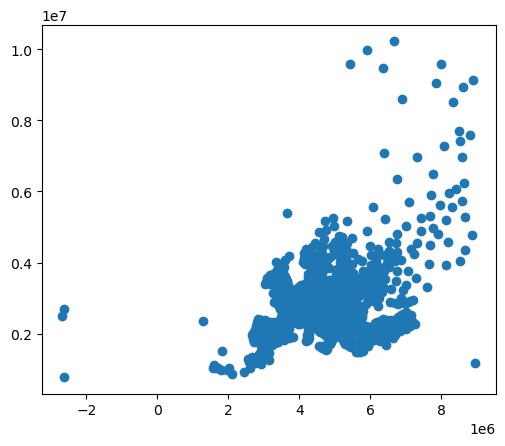

In [19]:
nuts3.plot()

In [20]:
nuts3.head()

,Unnamed: 0,ETISPlus_Zone_ID,Name,Country,Geometric_center,Geometric_center_X,Geometric_center_Y,Network_Node_ID,geometry
0,1097,101010101,Mittelburgenland,AT,POINT (16.4982 47.5051),16.4982,47.5051,106388,POINT (4810164.702 2731655.251)
1,1107,101010102,Nordburgenland,AT,POINT (16.7154 47.8762),16.7154,47.8762,106379,POINT (4822830.889 2774214.407)
2,1085,101010103,Sudburgenland,AT,POINT (16.2631 47.1438),16.2631,47.1438,106399,POINT (4795802.349 2690104.34)
3,1042,101010201,Mostviertel-Eisenwurzen,AT,POINT (14.9922 48.0445),14.9922,48.0445,106408,POINT (4693093.26 2782679.348)
4,1069,101010202,Niederosterreich-Sud,AT,POINT (15.776 47.7563),15.7760,47.7563,106439,POINT (4753819.691 2754988.848)


### Assign OD from local zones to network nodes

In [21]:
nearest_node_dict = func.find_nearest_node(nuts3, road_node_file) # zone_idx: node_idx
zone_to_node = {}
for zidx in range(nuts3.shape[0]):
    z = nuts3.loc[zidx, "ETISPlus_Zone_ID"]
    nidx = nearest_node_dict[zidx]
    n = road_node_file.loc[nidx, "Network_Node_ID"]
    zone_to_node[str(z)] = str(n)

In [22]:
for key, value in islice(zone_to_node.items(), 10):
    print(f"{key}: {value}")

101010101: 123694
101010102: 106379
101010103: 201937
101010201: 106408
101010202: 106439
101010203: 106431
101010204: 106474
101010205: 106500
101010206: 123711
101010207: 106567


In [23]:
od_cars_node_dict = defaultdict(lambda: defaultdict(list))
error = [] # identify idx of invalid od flows
for idx, row in od_cars.iterrows():
    from_zone = row["ORIGINZONE_3_ID"]
    to_zone = row["DEST_ZONE_3_ID"]
    try:
        from_node = zone_to_node[str(from_zone)]
        to_node = zone_to_node[str(to_zone)]
        trip = row["p_transport_car_trips"]
        od_cars_node_dict[from_node][to_node].append(trip)
    except KeyError:
        error.append(idx)
        continue

In [24]:
od_cars_node = od_cars.drop(index=error).reset_index(drop=True)

In [25]:
origins = []
destinations = []
pflows = []
for o, k in od_cars_node_dict.items():
    for d, v in k.items():
        origins.append(o)
        destinations.append(d)
        pflows.append(sum(v))

In [26]:
od_df = pd.DataFrame(data={"origin_node": origins, "destination_node": destinations, "Car21": pflows})

In [27]:
od_df.head()

,origin_node,destination_node,Car21
0,261026,104733,21
1,261026,261026,6213266
2,113361,196040,13
3,113361,115447,820
4,112471,104420,3


In [28]:
od_df.shape

(992, 3)

### Network flow modelling

In [29]:
# generate OD pairs
list_of_origin_nodes, dict_of_destination_nodes, dict_of_origin_supplies = (
    func.extract_od_pairs(od_df)
)

In [30]:
# flow simulation
(
    road_link_file,  # edge flow results
    isolated_od_dict,  # isolated trips
    odpfc, # od-path-flow-cost matrix
) = func.network_flow_model(
    road_link_file,  # road
    road_node_file,  # road
    list_of_origin_nodes,  # od
    dict_of_origin_supplies,  # od
    dict_of_destination_nodes,  # od
    free_flow_speed_dict,  # net
    flow_breakpoint_dict,  # net
    flow_capacity_dict,  # net
    min_speed_dict,  # net
    urban_speed_dict,  # net
    max_flow_speed_dict=None,  # disruption analysis
)

The initial total supply is 115371404
The initial number of edges in the network: 18446
The initial number of origins: 696
The initial number of destinations: 992
No.1 iteration starts:
The least-cost path flow allocation time: 4.550525903701782.
The od travel costs computational time: 2.0725691318511963.
Non_allocated_flow: 112250267
The remaining number of origins: 695
The remaining number of destinations: 989
The maximum amount of edge overflow: 177724.0
r = 0.5364382818450238
The total remaining supply (after flow adjustment) is: 1446839.6303170682
The remaining number of edges in the network: 18444
No.2 iteration starts:
The least-cost path flow allocation time: 3.9094760417938232.
The od travel costs computational time: 2.221196174621582.
Non_allocated_flow: 0
The remaining number of origins: 695
The remaining number of destinations: 989
The maximum amount of edge overflow: 156040.0
r = 0.06937424760360315
The total remaining supply (after flow adjustment) is: 1346466.219560746
T

### Export results: flow patterns, isolated trips, cost matrix

In [31]:
road_link_file.to_parquet(
    outpath / "gb_edge_flows.pq"
)
odpfc.to_parquet(outpath/ "odpfc.pq")
isolated_od_df = pd.Series(isolated_od_dict).reset_index()
if isolated_od_df.shape[0] != 0:  # in case of empty df
    isolated_od_df.columns = ["origin_node", "destination_node", "isolated_flows"]
    isolated_od_df.to_parquet(
        outpath/ "isolated_od_flows.pq",
        index=False,
    )

### Results demonstration

In [32]:
out_net_flows = gpd.read_parquet(outpath/ "edge_flows.pq")
out_net_flows.head()

,Network_Edge_ID,Manually_Added,Distance,Network_Node_A_ID,Network_Node_B_ID,Traffic_flow_trucks_2019,Traffic_flow_trucks_2030,geometry,id,e_id,...,form_of_way,urban,average_toll_cost,combined_label,free_flow_speeds,min_flow_speeds,initial_flow_speeds,acc_flow,acc_capacity,acc_speed
0,2604457,0,5.980,262914,260432,0,0,"LINESTRING (3482019.891 2730859.556, 3476692.4...",2604457,2604457,...,Dual Carriageway,0,0,M,67.0,1.0,67.0,0,205664,67.0
1,1013364,0,18.559,262914,109845,0,0,"LINESTRING (3482019.891 2730859.556, 3494854.6...",1013364,1013364,...,Dual Carriageway,0,0,M,67.0,1.0,67.0,0,205664,67.0
2,2604243,0,2.012,262911,109968,1871252,2513351,"LINESTRING (3393293.534 2897688.227, 3391385.3...",2604243,2604243,...,Dual Carriageway,0,0,M,67.0,1.0,67.0,0,205664,67.0
3,1013595,0,4.728,262911,122766,1871252,2513351,"LINESTRING (3393293.534 2897688.227, 3397490.3...",1013595,1013595,...,Dual Carriageway,0,0,M,67.0,1.0,67.0,0,205664,67.0
4,2604354,0,15.028,262909,260001,1038691,1449368,"LINESTRING (3725858.237 2258765.019, 3740417.8...",2604354,2604354,...,Dual Carriageway,0,0,M,67.0,1.0,67.0,10059,195604,67.0


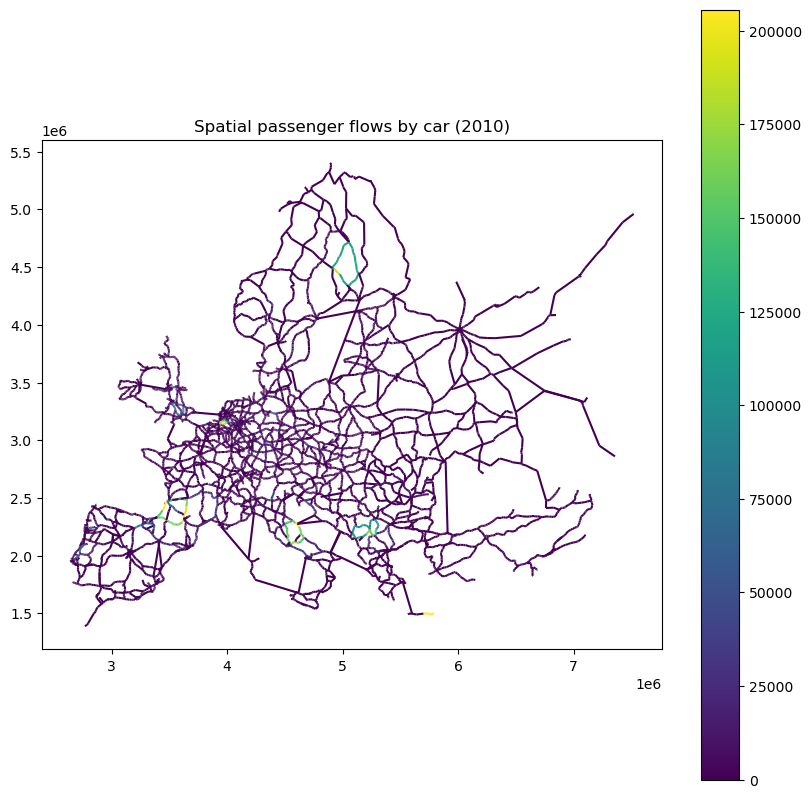

In [33]:
ax = out_net_flows.plot(column='acc_flow', 
              cmap='viridis',  
              legend=True,    
              figsize=(10, 10)) 

# Optionally, you can adjust the color scale range (e.g., for better visualization)
# You can also adjust axis, labels, etc.
plt.title('Spatial passenger flows by car (2010)')
plt.show()

In [34]:
trip_isolation = pd.read_parquet(outpath/ "isolated_od_flows.pq")
trip_isolation.isolated_flows = trip_isolation.isolated_flows.astype(int)

In [35]:
trip_isolation.head()

,origin_node,destination_node,isolated_flows
0,101166,101166,80776620
1,190533,190533,25260381
2,261026,261026,6213266
3,104438,104441,156040


In [36]:
odpfc = pd.read_parquet(outpath / "odpfc.pq")

In [37]:
odpfc

,origin,destination,path,flow,unit_od_voc,unit_od_vot,unit_od_toll
0,100282,125366,"[1000218, 1035423, 1000221, 2608035, 2616054, ...",56.767398,90.327400,119.437947,0.0
1,100282,196790,"[1000218, 1035423, 1000221, 2608035, 1009604, ...",506.539862,52.885416,69.929229,0.0
2,100310,107533,"[1034850, 2608082, 1000240, 1000232, 1000235, ...",72.050929,67.360513,89.069334,0.0
3,100368,116743,"[1301165, 1000287, 1000296, 1301265, 1034885, ...",5.684893,103.550058,136.921978,0.0
4,100368,116957,"[1301165, 1000287, 1000296, 1301265, 1034885, ...",15.000000,103.942621,137.441055,0.0
...,...,...,...,...,...,...,...
1244,261697,148954,"[1055748, 2615425, 2615424, 2616179, 1055642, ...",12331.625595,25.074252,33.155135,0.0
1245,261801,251940,"[2615531, 2615530, 2615268, 1055753, 1309249, ...",3.789928,196.977869,260.459531,0.0
1246,261816,251845,"[2615440, 2615439, 2615438, 2615437, 1055641, ...",9.474821,269.101039,355.826421,0.0
1247,261938,250906,"[1005452, 1004960, 1005458, 1005457, 2615191, ...",11.369785,151.614662,200.476753,0.0
